# KCCA Tutorial

This algorithm runs KCCA on two views of data. The kernel implementations, parameter 'ktype', are linear, polynomial and gaussian. Polynomial kernel has two parameters: 'constant', 'degree'. Gaussian kernel has one parameter: 'sigma'.

When initializing KCCA, you can also initialize the following parameters: the number of canonical components 'n_components', the regularization parameter 'reg', the decomposition type 'decomposition', and the decomposition method 'method'.

In [1]:
%matplotlib inline
import numpy as np
import sys
sys.path.append("../../..")
from mvlearn.embed.kcca import KCCA
from mvlearn.plotting.plot import crossviews_plot
import matplotlib.pyplot as plt
from scipy import stats
np.random.seed(1)

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

/Users/theodorelee/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


Function creates Xs, a list of two views of data with a linear relationship, polynomial relationship (2nd degree) and a gaussian (sinusoidal) relationship.

In [2]:
def make_data(kernel, N):
    # # # Define two latent variables (number of samples x 1)
    latvar1 = np.random.randn(N,)
    latvar2 = np.random.randn(N,)
    
    # # # Define independent components for each dataset (number of observations x dataset dimensions)
    indep1 = np.random.randn(N, 4)
    indep2 = np.random.randn(N, 5)
    
    if kernel == "linear":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "gaussian":
        t = np.random.uniform(-np.pi, np.pi, N)
        e1 = np.random.normal(0, 0.05, (N,2))
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return [x,y]

# Linear kernel implementation

In [3]:
Xs = make_data('linear', 100)
Xs_train = [Xs[0][:20],Xs[1][:20]]
Xs_test = [Xs[0][20:],Xs[1][20:]]

kcca_l = KCCA(n_components = 4, reg = 0.01)
kcca_l.fit(Xs_train)
linearkcca = kcca_l.transform(Xs_test)

## Original Data Plotted

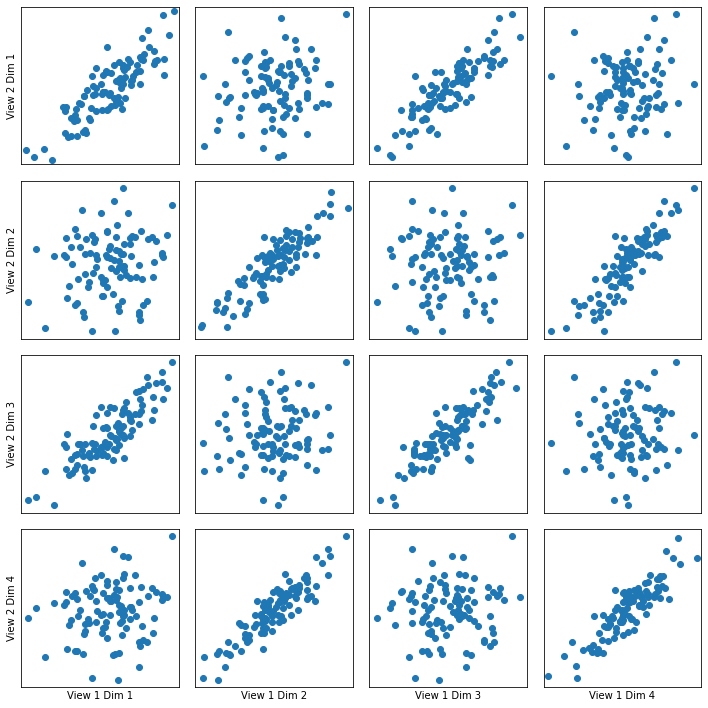

In [4]:
crossviews_plot(Xs, ax_ticks=False, ax_labels=True, equal_axes=True)

## Transformed Data Plotted

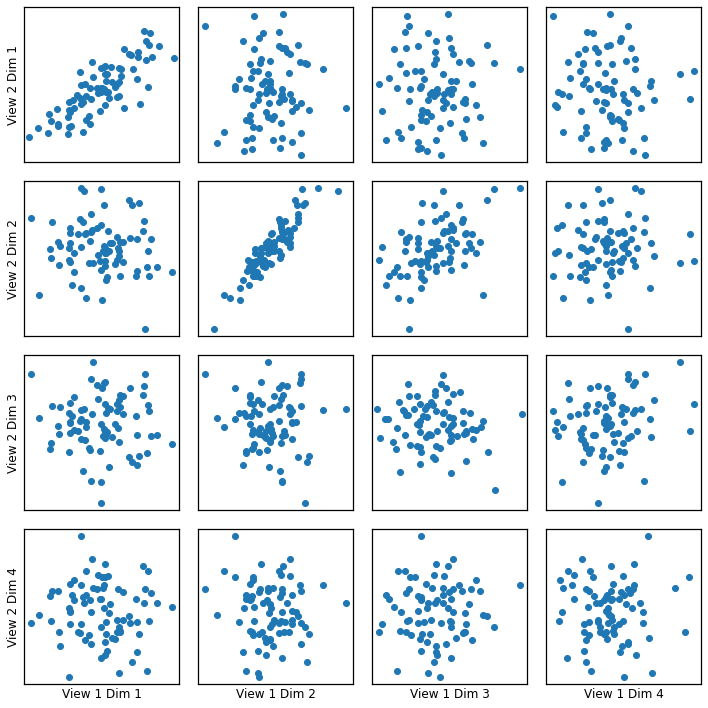

In [5]:
crossviews_plot(linearkcca, ax_ticks=False, ax_labels=True, equal_axes=True)

In [6]:
(r1, _) = stats.pearsonr(linearkcca[0][:,0], linearkcca[1][:,0])
(r2, _) = stats.pearsonr(linearkcca[0][:,1], linearkcca[1][:,1])
(r3, _) = stats.pearsonr(linearkcca[0][:,2], linearkcca[1][:,2])
(r4, _) = stats.pearsonr(linearkcca[0][:,3], linearkcca[1][:,3])

print("Below are the canonical correlation for the four components:")
print(r1,r2,r3,r4)

Below are the canonical correlation for the four components:
0.801051068062792 0.9152662124091224 -0.10641730382387343 -0.014649450572449443


# Polynomial kernel implementation

In [7]:
Xsp = make_data("poly", 150)
kcca_p = KCCA(ktype ="poly", degree = 2.0, n_components = 2, reg=0.001)
polykcca = kcca_p.fit_transform(Xsp)

## Original Data Plotted

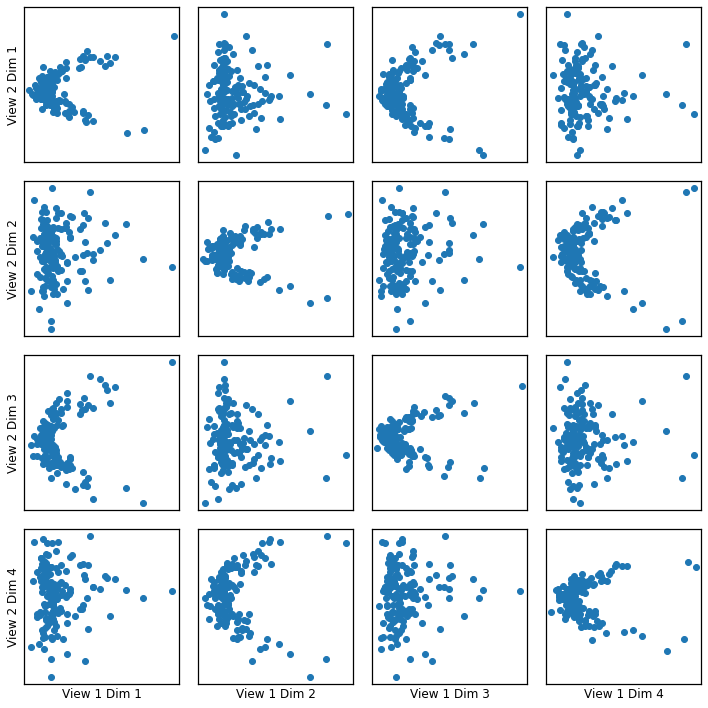

In [8]:
crossviews_plot(Xsp, ax_ticks=False, ax_labels=True, equal_axes=True)

## Transformed Data Plotted

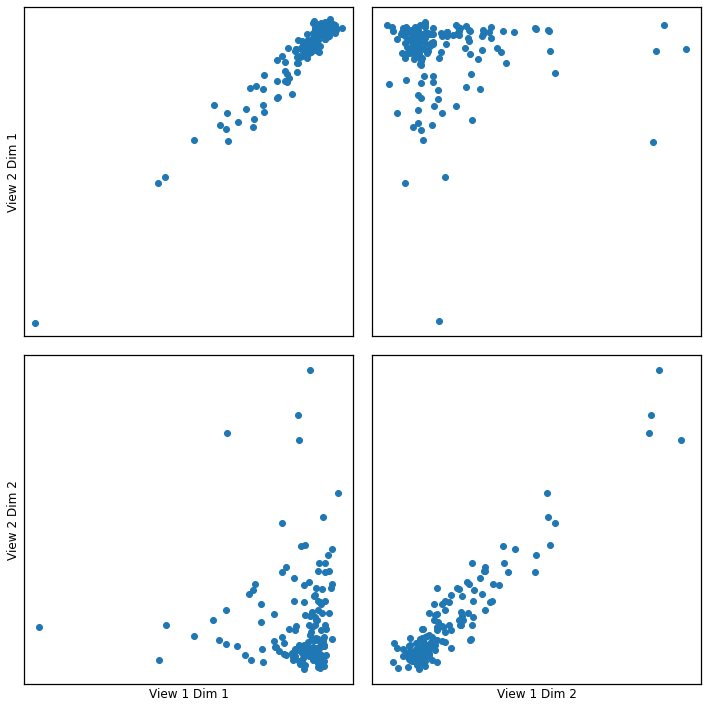

In [9]:
crossviews_plot(polykcca, ax_ticks=False, ax_labels=True, equal_axes=True)

In [10]:
(pr1, _) = stats.pearsonr(polykcca[0][:,0], polykcca[1][:,0])
(pr2, _) = stats.pearsonr(polykcca[0][:,1], polykcca[1][:,1])


print("Below are the canonical correlation for the two components:")
print(pr1,pr2)

Below are the canonical correlation for the two components:
0.9673839623723469 0.9450028494239876


# Gaussian Kernel Implementation

In [11]:
Xsg = make_data("gaussian", 100)
Xsg_train = [Xsg[0][:20],Xsg[1][:20]]
Xsg_test = [Xsg[0][20:],Xsg[1][20:]]

In [12]:
# Full kettering method
kcca_g = KCCA(ktype ="gaussian", sigma = 3.0, n_components = 2, reg = 0.01)
kcca_g.fit(Xsg)
gausskcca = kcca_g.transform(Xsg)

In [13]:
# Standard hardoon method
kcca_g_std_h = KCCA(ktype ="gaussian", sigma = 3.0, n_components = 2, reg = 0.01, method = 'standard_hardoon')
kcca_g_std_h.fit(Xsg)
gausskcca_std_h = kcca_g_std_h.transform(Xsg)

In [14]:
# Simplified hardoon method
kcca_g_simp_h = KCCA(ktype ="gaussian", sigma = 3.0, n_components = 2, reg = 0.01, method = 'simplified_hardoon')
kcca_g_simp_h.fit(Xsg)
gausskcca_simp_h = kcca_g_simp_h.transform(Xsg)

## Original Data Plotted

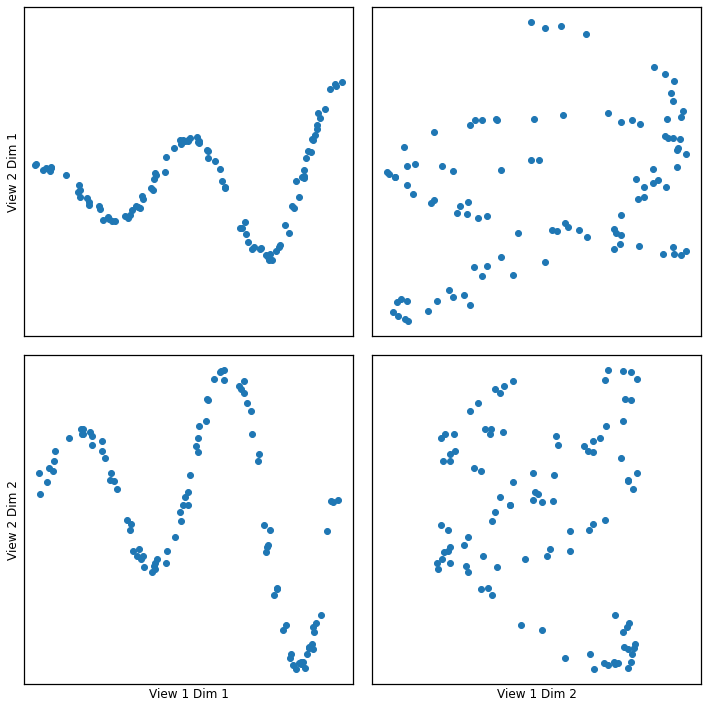

In [15]:
crossviews_plot(Xsg, ax_ticks=False, ax_labels=True, equal_axes=True)

## Transformed Data Plotted

### Full kettering method

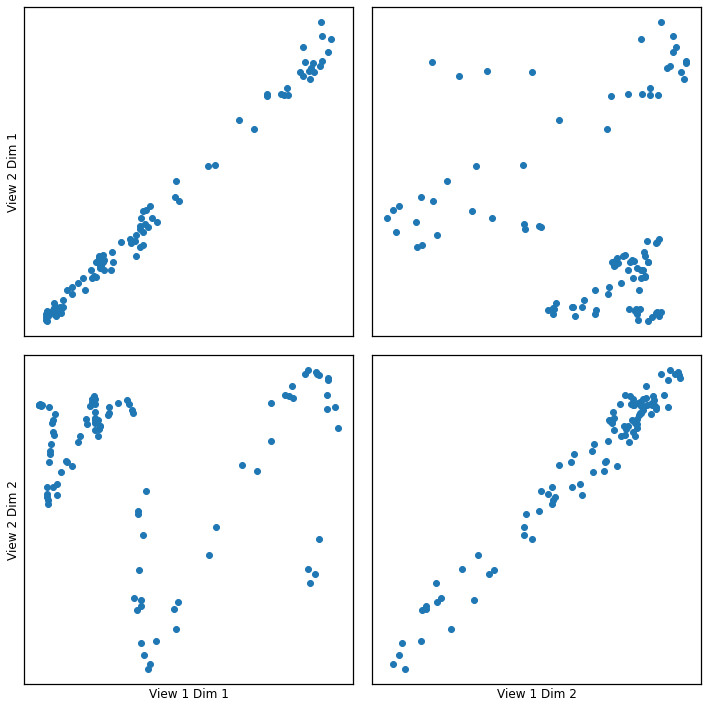

In [16]:
crossviews_plot(gausskcca, ax_ticks=False, ax_labels=True, equal_axes=True)

### Standard hardoon method

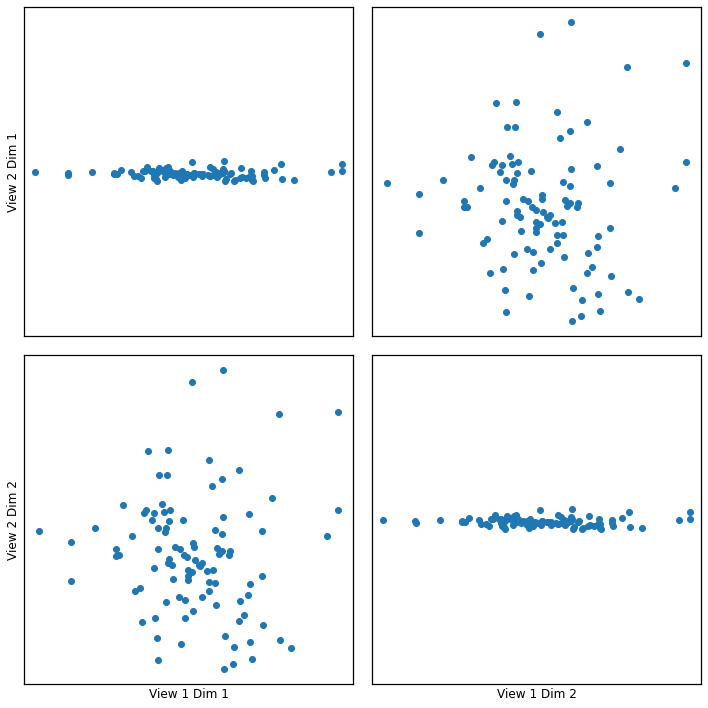

In [17]:
crossviews_plot(gausskcca_std_h, ax_ticks=False, ax_labels=True, equal_axes=True)

### Simplified hardoon method

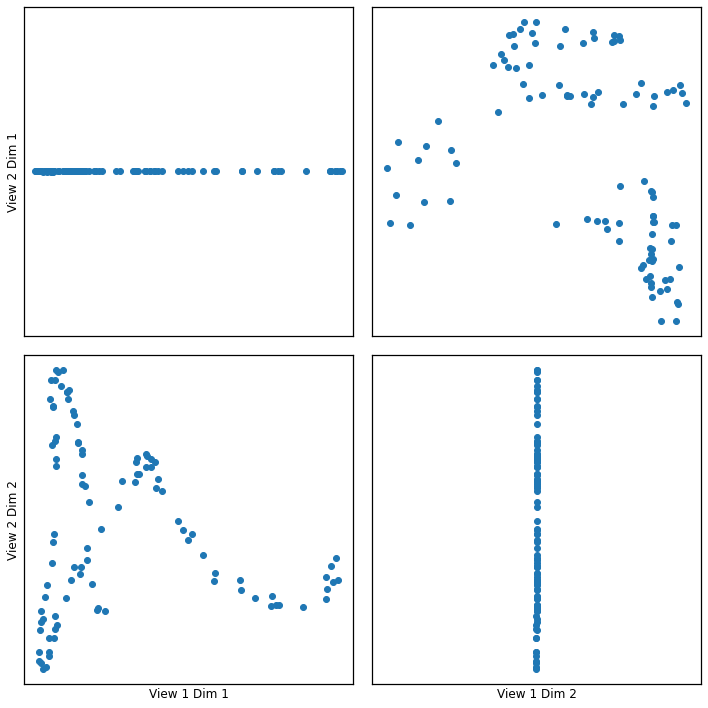

In [18]:
crossviews_plot(gausskcca_simp_h, ax_ticks=False, ax_labels=True, equal_axes=True)

In [19]:
(gr1, _) = stats.pearsonr(gausskcca[0][:,0], gausskcca[1][:,0])
(gr2, _) = stats.pearsonr(gausskcca[0][:,1], gausskcca[1][:,1])

print("Below are the canonical correlation for full kettering method:")
print(gr1,gr2)

Below are the canonical correlation for full kettering method:
0.9952722505716556 0.9823764035712282


In [20]:
(gr1, _) = stats.pearsonr(gausskcca_std_h[0][:,0], gausskcca_std_h[1][:,0])
(gr2, _) = stats.pearsonr(gausskcca_std_h[0][:,1], gausskcca_std_h[1][:,1])

print("Below are the canonical correlation for standard hardoon:")
print(gr1,gr2)

Below are the canonical correlation for standard hardoon:
-0.03771826033701636 -0.03768284056920485


In [21]:
(gr1, _) = stats.pearsonr(gausskcca_simp_h[0][:,0], gausskcca_simp_h[1][:,0])
(gr2, _) = stats.pearsonr(gausskcca_simp_h[0][:,1], gausskcca_simp_h[1][:,1])

print("Below are the canonical correlation for simplified hardoon:")
print(gr1,gr2)

Below are the canonical correlation for simplified hardoon:
0.7991788923095445 0.6768448825585687
